# A movie recommender using KNN of user ratings

- The data for **from-dusk-til-deploy** is publicly available and can be found here 'https://grouplens.org/datasets/movielens/'.
- I've used the smaller data set *'ml-latest-small.zip'*, but the model should work on the bigger data as well.
- Thanks for checking out my project, I'll make sure to keep it as light and fluffy as a baby xenomorph.

### 1. Importing the basic modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

%matplotlib inline

# You may be asking yourself "why matplotlib, why seaborn? In 
# what way do you need to EDA a recommender system?" 
# To which I say – "Ni!"

# Joking aside, it's in my nature to double-chack and analyse

### 2. As the baby raptor breaks through the egg, so does our data poke it's head out of a csv.

- I'll only be using the *movies.csv* and *ratings.csv* as they are the basis for the KNN model.
- I'll delete the other csv's for space-saving reasons, but they're still publicly available.
- This section is to load and inspect the data.

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# For the recommnder, I don't need the genre from movies or the
# timestamp from ratings, so I'll drop these 2 columns

movies = movies.drop(columns='genres')
ratings = ratings.drop(columns='timestamp')

In [6]:
# The column drop was succesful and we can see there are over
# 9000 movies

movies.shape

(9742, 2)

In [7]:
# Here we have more than 100 000 ratings, but only 610 users
# This info is also available on https://grouplens.org/datasets/movielens/

ratings.shape, ratings["userId"].nunique()

((100836, 3), 610)

### 3. Birth of the feature set

- I could use a real easy Matrix pun right here, but I won't.
- It's time to use a collaborative feature set to create a sparse matrix.
- Simply put, create a matrix with all the movies as columns and the users as rows, then fill it up with the ratings.
- This means there'll be a lot of 0's, but that's okay. We need 0's. Lot's f 0's.
- To save the model some effort, I'll filter out movies with almost no ratings.

In [8]:
# First let's get a up close and personal with the number of
# ratings per movie.

no_of_ratings = (ratings
                   .groupby('movieId', as_index=False)
                   .agg({'userId':'count'})
                   .rename(columns={'userId':'no_of_ratings'}))

In [9]:
no_of_ratings.head()

,movieId,no_of_ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [10]:
# Let's merge our dataframes

df = ratings.merge(movies, how='left', on='movieId')

In [11]:
df = df.merge(no_of_ratings, how='left', on='movieId')

In [12]:
df.head()

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


In [13]:
# checking out the last index and row total, we have
# about 20 000 movies with < 10 ratings
df[df['no_of_ratings'] > 10]

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204
...,...,...,...,...,...
100818,610,159093,3.0,Now You See Me 2 (2016),11
100829,610,164179,5.0,Arrival (2016),26
100830,610,166528,4.0,Rogue One: A Star Wars Story (2016),27
100833,610,168250,5.0,Get Out (2017),15


### 4.1 Let's get into some analysis

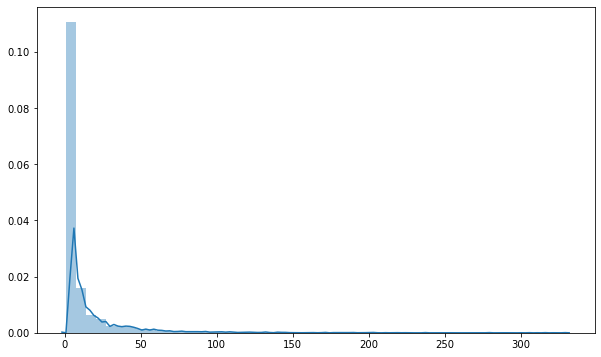

In [14]:
# First things first, I want to see how the ratings count
# is distributed

plt.figure(figsize=(10,6))
sns.distplot(no_of_ratings.set_index('movieId'))

In [15]:
no_of_ratings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
movieId,9724.0,42245.024373,52191.137320,1.0,3245.5,7300.0,76739.25,193609.0
no_of_ratings,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.00,329.0


In [16]:
# I don't want to get rid of 20 000 movies, so I'll
# set the min number of ratings to 5

final_movies = df[df['no_of_ratings'] >= 5].copy()

In [17]:
final_movies

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204
...,...,...,...,...,...
100830,610,166528,4.0,Rogue One: A Star Wars Story (2016),27
100831,610,166534,4.0,Split (2017),6
100832,610,168248,5.0,John Wick: Chapter Two (2017),7
100833,610,168250,5.0,Get Out (2017),15


### 4.2 Convert the dataframe into a sparse matrix

In [18]:
movie_features = final_movies.pivot_table(index='movieId',
                                            columns='userId',
                                            values='rating').fillna(0)

In [19]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Time to pickle, because this is the final df we'll be using 
# for the model and I don't want the actual data-set to take
# up space on github.

with open('app/movie_features.pkl', 'wb') as mf:
    pickle.dump(movie_features, mf, protocol=pickle.HIGHEST_PROTOCOL)

### 5. Time to set up the KNN model
#### 5.1 First compress the sparse matrix to allow for faster row access

In [21]:
from scipy.sparse import csr_matrix

In [22]:
matrix_mfeatures = csr_matrix(movie_features)

In [23]:
matrix_mfeatures

<3650x610 sparse matrix of type '<class 'numpy.float64'>'
	with 90274 stored elements in Compressed Sparse Row format>

#### 5.2 Time to import and train KNN (K-Nearest-Neighbors)

In [24]:
from sklearn.neighbors import NearestNeighbors

In [25]:
# Using cosine similarity distance measure

model_knn = NearestNeighbors(metric='cosine',
                             algorithm='brute',
                             n_jobs=-1)

model_knn.fit(matrix_mfeatures)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [26]:
with open('app/model_knn.pkl', 'wb') as mk:
    pickle.dump(model_knn, mk, protocol=pickle.HIGHEST_PROTOCOL)

#### 5.3 A quick test run to check if the model works

In [27]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Creating an array we can use the model on (rough work)

movie_features.loc[1].values.reshape(1,-1)

array([[4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
        3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
        4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
        0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
        0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
        0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
        3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
        0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
        0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. 

In [29]:
# the second array is the index of the nearest neighbors
# it is not the movieId of the original data

model_knn.kneighbors(movie_features.loc[1].values.reshape(1,-1), n_neighbors=6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]]))

In [30]:
# Let's find out what 306 is

movie_features.iloc[306]

userId
1      4.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    2.5
607    4.0
608    3.0
609    3.0
610    5.0
Name: 480, Length: 610, dtype: float64

In [31]:
movies[movies['movieId'] == 480]

,movieId,title
418,480,Jurassic Park (1993)


### 6. Making the recommender more user-friendly
#### 6.1 We need the model output to be movie titles, not the array indices.

In [32]:
distances, indices = model_knn.kneighbors(movie_features.loc[1]
                                                        .values
                                                        .reshape(1,-1), n_neighbors=6)

In [33]:
indices

array([[   0, 1545,  306,  429,  169,  231]])

In [34]:
# Creating a movie df more accessible to the KNN output

movie_list = (final_movies[['movieId', 'title']].drop_duplicates()
                                                .sort_values('movieId')
                                                .reset_index(drop=True))

In [35]:
movie_list.iloc[306]

movieId                     480
title      Jurassic Park (1993)
Name: 306, dtype: object

In [36]:
with open('app/movie_list.pkl', 'wb') as ml:
    pickle.dump(movie_list, ml, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
indices.flatten()

array([   0, 1545,  306,  429,  169,  231])

In [38]:
for i,j in enumerate(indices.flatten()):
    movie = movie_list.iloc[j]
    name = movie['title']
    if i == 0:
        print(f'Users who liked {name} also like:')
        print('----------------------------------------------\n')
    else:
        print(f'{i}: {name}')
        

Users who liked Toy Story (1995) also like:
----------------------------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


In [90]:
m_selection = []

for i,j in enumerate(indices.flatten()):
    movie = movie_list.iloc[j]
    name = movie['title']

    if i == 0:
        or_movie = f'Users who liked {name} also like:'
    
    else:
        m_selection.append(name)
        

In [91]:
movie

movieId                    356
title      Forrest Gump (1994)
Name: 231, dtype: object

In [92]:
name

'Forrest Gump (1994)'

In [93]:
type(or_movie)

str

In [96]:
type(m_selection)

list

In [101]:
# Putting it all in a function

def print_recommendations(knn_output):
    distances, indices = knn_output
    
    for i,res in enumerate(zip(distances.flatten(), indices.flatten())):
        distance, index = res
        name = movie_list.iloc[index]['title']
        if i == 0:
            print(f'Users who liked {name} also like:')
            print('----------------------------------------------\n')
        else:
            print(f'{i}: {name}')

In [105]:
# Testing out function that will return string and list instead of nonetype

def print_recommendations(knn_output):
    distances, indices = knn_output
    m_selection = []
    
    for i,res in enumerate(zip(distances.flatten(), indices.flatten())):
        distance, index = res
        name = movie_list.iloc[index]['title']
        if i == 0:
            or_movie = f'Users who liked {name} also like:'
        else:
            m_selection.append(name)
    
    return or_movie, m_selection

In [104]:
print_recommendations(model_knn.kneighbors(movie_features.loc[1]
                                                        .values
                                                        .reshape(1,-1), n_neighbors=6))

('Users who liked Toy Story (1995) also like:',
 ['Toy Story 2 (1999)',
  'Jurassic Park (1993)',
  'Independence Day (a.k.a. ID4) (1996)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Forrest Gump (1994)'])

#### 6.2 Creating a movie-vector from movieId

In [41]:
# so we don't need to keep loccing, valuing and reshaping

def movieid_vec(movie_id):
    return movie_features.loc[movie_id].values.reshape(1, -1)

In [42]:
movieid_vec(1)

array([[4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
        3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
        0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
        4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
        0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
        0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
        0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
        0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
        0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
        3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
        0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
        0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. 

In [43]:
print_recommendations(model_knn.kneighbors(movieid_vec(1), n_neighbors=6))

Users who liked Toy Story (1995) also like:
----------------------------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


#### 6.3 Allow movie titles as input

In [44]:
movie_list.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [45]:
movie_list.set_index('movieId').to_dict()['title']

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 34: 'Babe (1995)',
 36: 'Dead Man Walking (1995)',
 39:

In [46]:
movie_map = {title: movie_id for movie_id, title in movie_list.set_index('movieId')
                                                                .to_dict()['title']
                                                                .items()}

In [47]:
movie_map['Jumanji (1995)']

2

In [48]:
with open('app/movie_map.pkl', 'wb') as mm:
    pickle.dump(movie_map, mm, protocol=pickle.HIGHEST_PROTOCOL)

#### 6.4 Using fuzzy string matching to account for mispellings

In [49]:
from fuzzywuzzy import fuzz

In [50]:
fuzz.ratio('goldeney', 'GoldenEye (1995)'.lower())

67

In [51]:
# Getting rid of the year numbers
import re

In [52]:
test_title = "City of Lost Children, The (Cité des enfants perdus, La) (1995)"

In [53]:
title_pattern = r'(.*)\s\(\d{4}\)$'
test_title, = re.findall(title_pattern, test_title)

In [54]:
test_title

'City of Lost Children, The (Cité des enfants perdus, La)'

#### 6.5 Function that takes the search query and returns movieId

In [55]:
def get_movieid(query):
    matches = []
    
    for title, movie_id in movie_map.items():
        
        # removing the year
        year_pattern = r'(.*)\s\(\d{4}\)$'
        extr_title, = re.findall(year_pattern, title)
        
        # get fuzz ration and remove CAsE-sEnsITiVity
        ratio = fuzz.ratio(extr_title.lower(), query)
        
        # ration must be more than 60 in order to match
        if ratio > 60:
            matches.append((extr_title, movie_id, ratio))
    
    if not matches:
        print('Oops, we couldn\'t find what you were looking for.')
        return
    
    # sorts the list of matches, with the highest ratio on top
    return sorted(matches, key=lambda x: x[2], reverse=True)[0][1]

In [56]:
get_movieid('walleye')

60069

In [57]:
# quick test to see if it works
print_recommendations(model_knn.kneighbors(movieid_vec(60069), n_neighbors=6))

Users who liked WALL·E (2008) also like:
----------------------------------------------

1: Up (2009)
2: Iron Man (2008)
3: Avatar (2009)
4: Dark Knight, The (2008)
5: Inception (2010)


In [58]:
def recommend_movies(query, n=5):
    movie_id = get_movieid(query)
    if not movie_id:
        return
    
    movie_vec = movieid_vec(movie_id)
    
    n_recs = n + 1
    recs = model_knn.kneighbors(movie_vec, n_neighbors=n_recs)
    
    print_recommendations(recs)

In [59]:
recommend_movies('walley')

Users who liked WALL·E (2008) also like:
----------------------------------------------

1: Up (2009)
2: Iron Man (2008)
3: Avatar (2009)
4: Dark Knight, The (2008)
5: Inception (2010)


In [60]:
recommend_movies('ip man')

Users who liked Ip Man (2008) also like:
----------------------------------------------

1: Ip Man 2 (2010)
2: The Raid 2: Berandal (2014)
3: Fast & Furious (Fast and the Furious 4, The) (2009)
4: The Raid: Redemption (2011)
5: Fast Five (Fast and the Furious 5, The) (2011)


## This is the end...
### The model is finished and works. Now it's time to prep everything to deploy.

### So far we have these jars:
- movie_features.pkl (the sparse matrix)
- model_knn.pkl (speaks for itself)
- movie_list.pkl (movie id's and titles)
- movie_map.pkl (dictionary of movie id's and titles)

### These are the current functions we need (bottom up)
- recommend_movies() – uses get_movieid(), movieid_vec(), model_knn.kneighbors(), print_recommendations
- get_movieid() – uses movie_map
- movieid_vec() – uses movie_features
- model_knn.kneighbors() - uses movie_features
- print_recommendations() - movie_list